本代码来源：[kaggle discussion](https://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb)


## Rossmann Store Sales

In [144]:
from IPython.display import display

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

import pylab
import csv
import datetime
import math
import re
import time
import random
import os

from pandas.tseries.offsets import *
from operator import *

from sklearn.cross_validation import train_test_split

%matplotlib inline

# plt.style.use('ggplot') # Good looking plots
# 1.用来控制np.array的输出
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

# 2.设置参数
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

start_time = time.time()

In [146]:
# 构建评价指标
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

# xgboost中的rmpse
def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

## Set seed

In [147]:
seed = 42

## Reading sales data

In [148]:
nrows = None

df_train = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/train.csv', 
                       nrows=nrows,
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

nrows = nrows

df_submit = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/test.csv', 
                        nrows=nrows,
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

/Users/mingj/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [149]:
### Setting a variable to easily distinguish train (1) from submit (0) set
df_train['Set'] = 1
df_submit['Set'] = 0

In [150]:
### frames是将两个dataframe合并成一个list，pd.concat()默认取并集，纵向连接
frames = [df_train, df_submit]
df = pd.concat(frames)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058286 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [198]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [153]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [154]:
# df.loc选取指定的行和列
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales']) # = np.log(df['Sales'] + 1)

In [155]:
# 相当于对这一列的值数值化。思路是先转换为category型，再转变为数值。
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [199]:
# 通过Date获取信息：Day，Week等
var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

# 在特征里删除'Date'，增加提取的上述特征
features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [157]:
# 转化为整形
df['DateInt'] = df['Date'].astype(np.int64)

## Reading store data

In [158]:
df_store = pd.read_csv('./参考资料/kaggle-rossman-store-sales/input/store.csv', 
                       nrows=nrows)

In [159]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [160]:
### 将类别转化为数值型
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [161]:
### Convert competition open year and month to float
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

df_store['CompetitionOpenInt'] = df_store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [162]:
### Convert competition open year and month to float
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

df_store['Promo2SinceFloat'] = df_store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [163]:
# 现将'PromoInterval'包含的元素分隔开，分为了4列；再重命名；再将其与df_store合并
s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)

In [164]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

# map的主要作用是将函数作用于一个Series的每一个元素
df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [165]:
del df_store['PromoInterval']

In [200]:
store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt',
                  'PromoInterval0']

### Features not helping
# PromoInterval1, PromoInterval2, PromoInterval3

features_x = list(set(features_x + store_features))

In [167]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [168]:
### 把特征中的NA转为-1；Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

## Manually Check and Correct some Strange Data in Stores

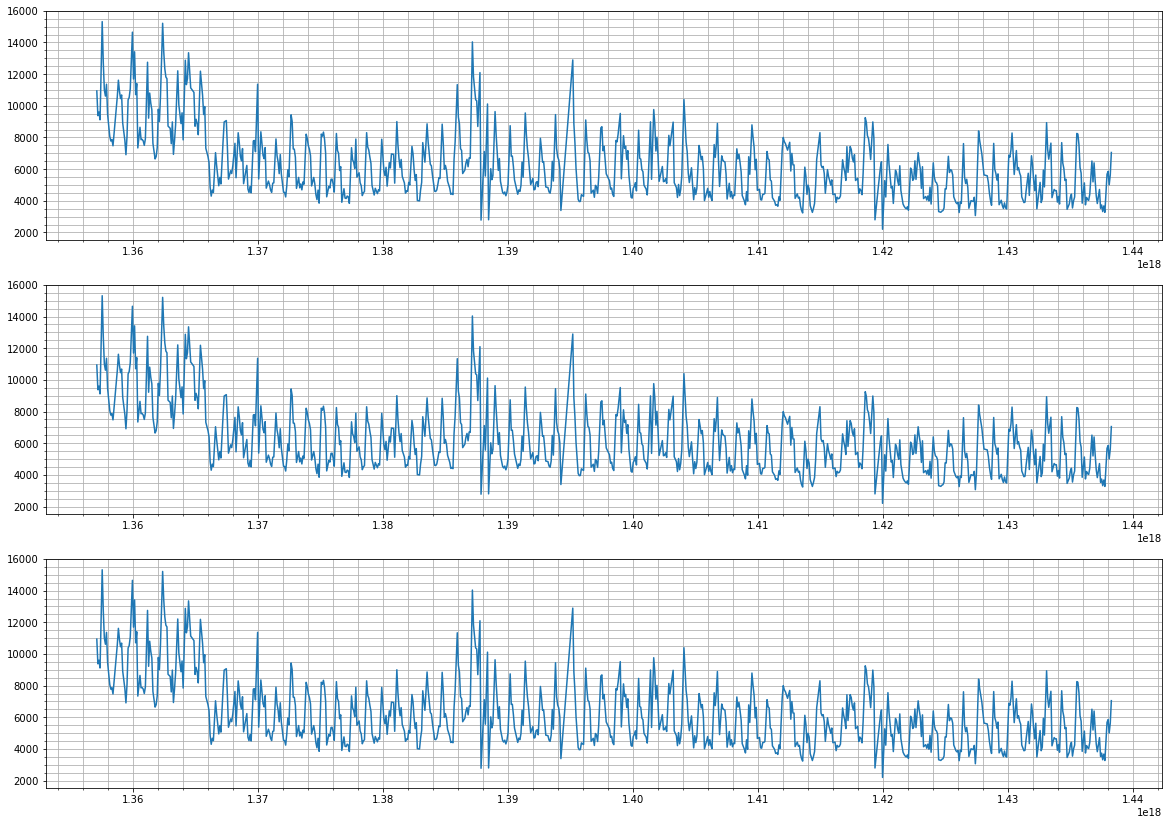

In [81]:
test1 = df.loc[(df['Set'] == 1) & (df['Store'] == 1) & (df['Open'] == 1)]
y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']
plt.subplot(20,1,1)
plt.plot(X1['DateInt'], y1, '-')
plt.minorticks_on()
plt.grid(True, which='both')
plt.subplot(20,1,2)
plt.plot(X1['DateInt'], y1, '-')
plt.minorticks_on()
#
plt.grid(True, which='both')
plt.subplot(20,1,3)
plt.plot(X1['DateInt'], y1, '-')
plt.minorticks_on()
plt.grid(True, which='both')

In [ ]:
plt.grid(True, which='both')

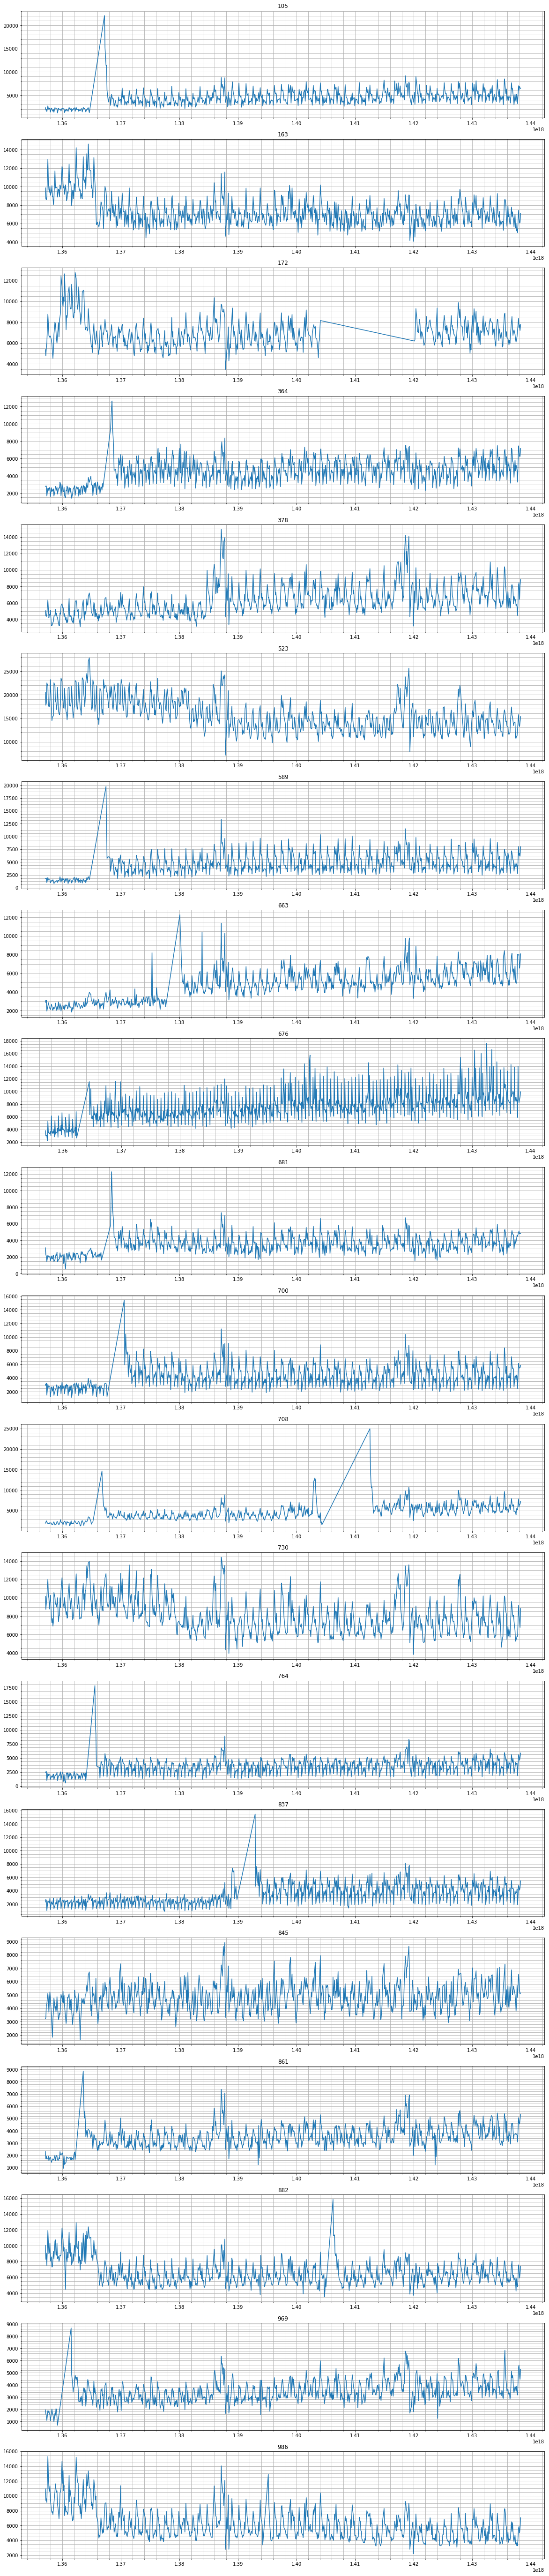

In [73]:
# 为什么选择这些店铺去检查？
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    # 图分为几份
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    # 使用默认的刻度显示
    plt.minorticks_on()
    # 显示背景的网格
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

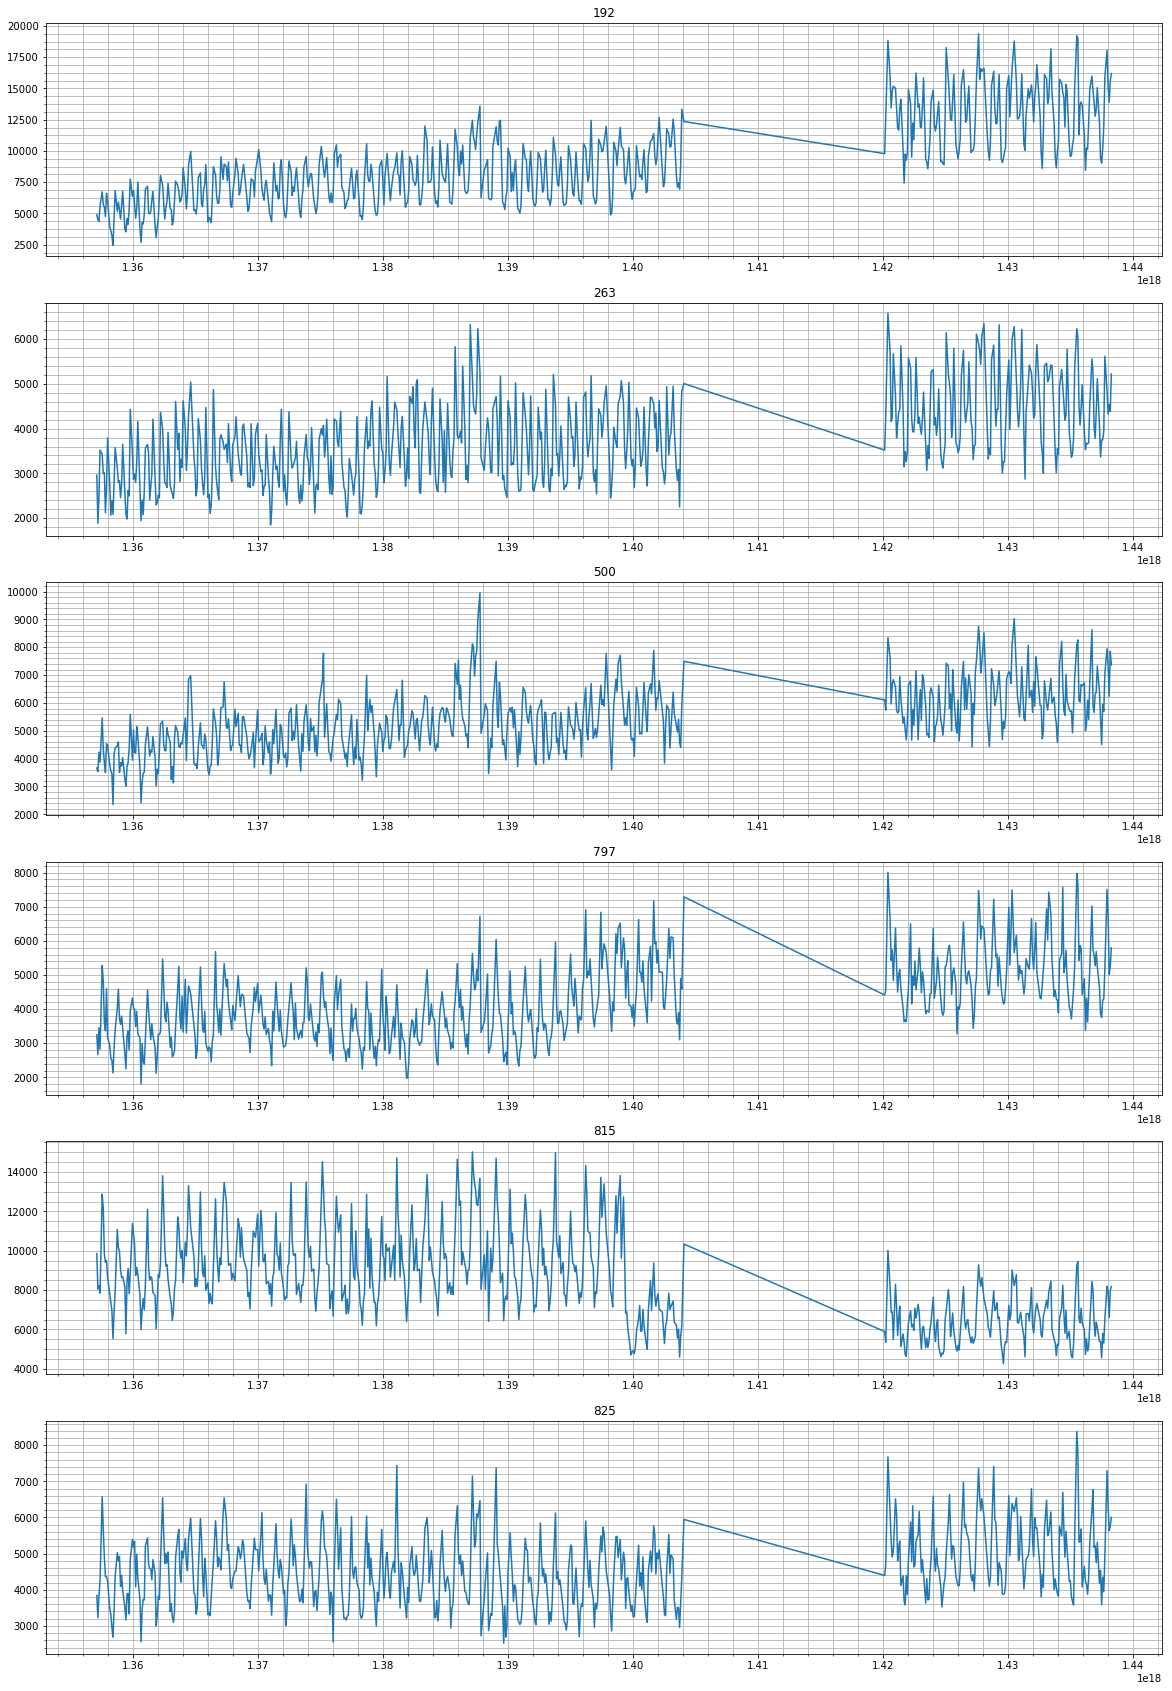

In [82]:
list_stores_to_check = [192,263,500,797,815,825]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

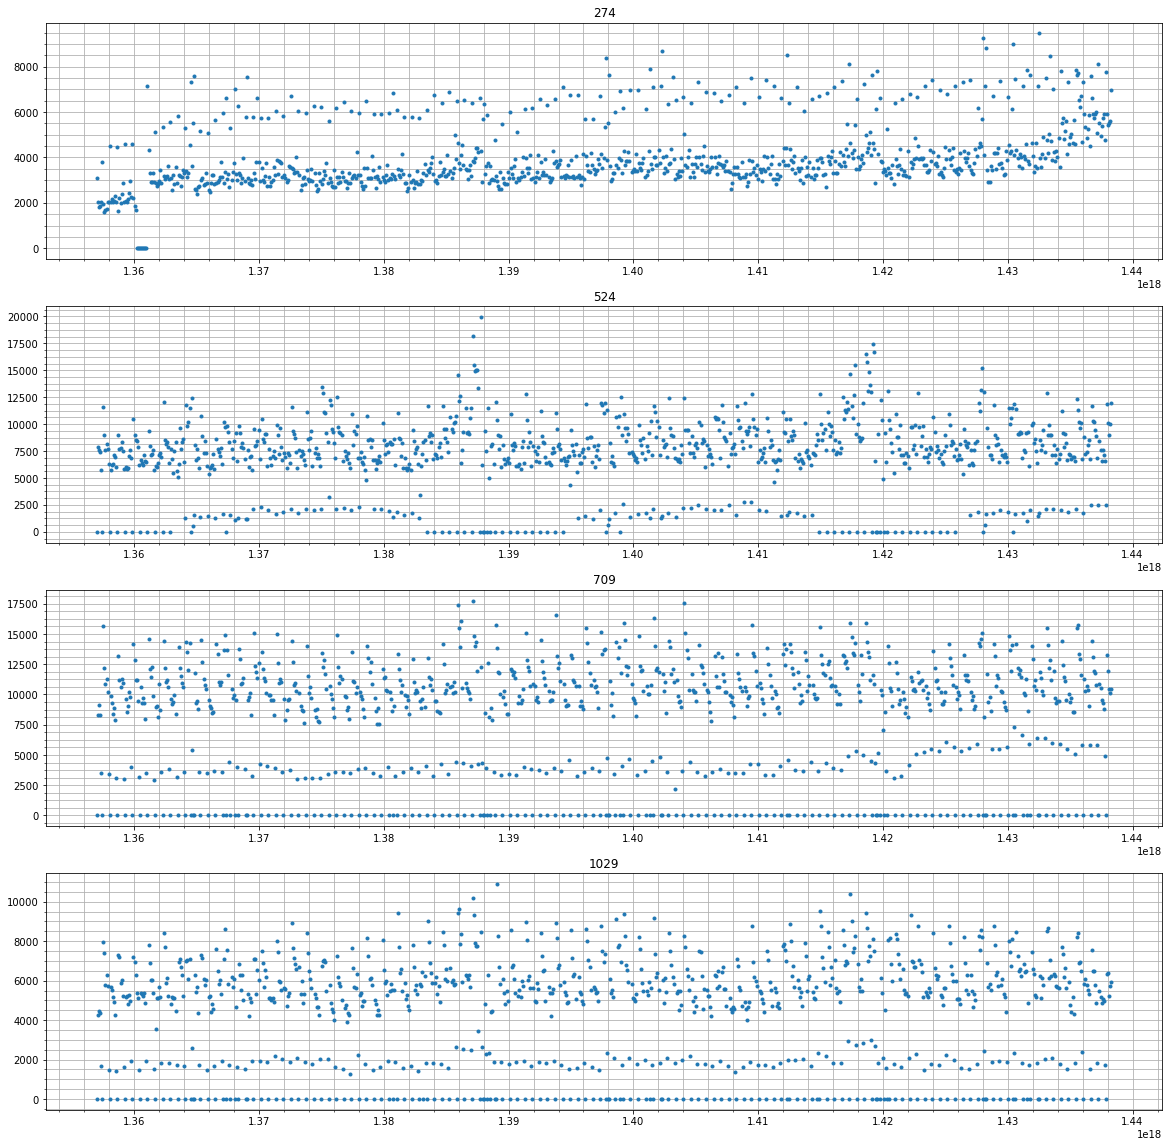

In [83]:
list_stores_to_check = [274,524,709,1029]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '.')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

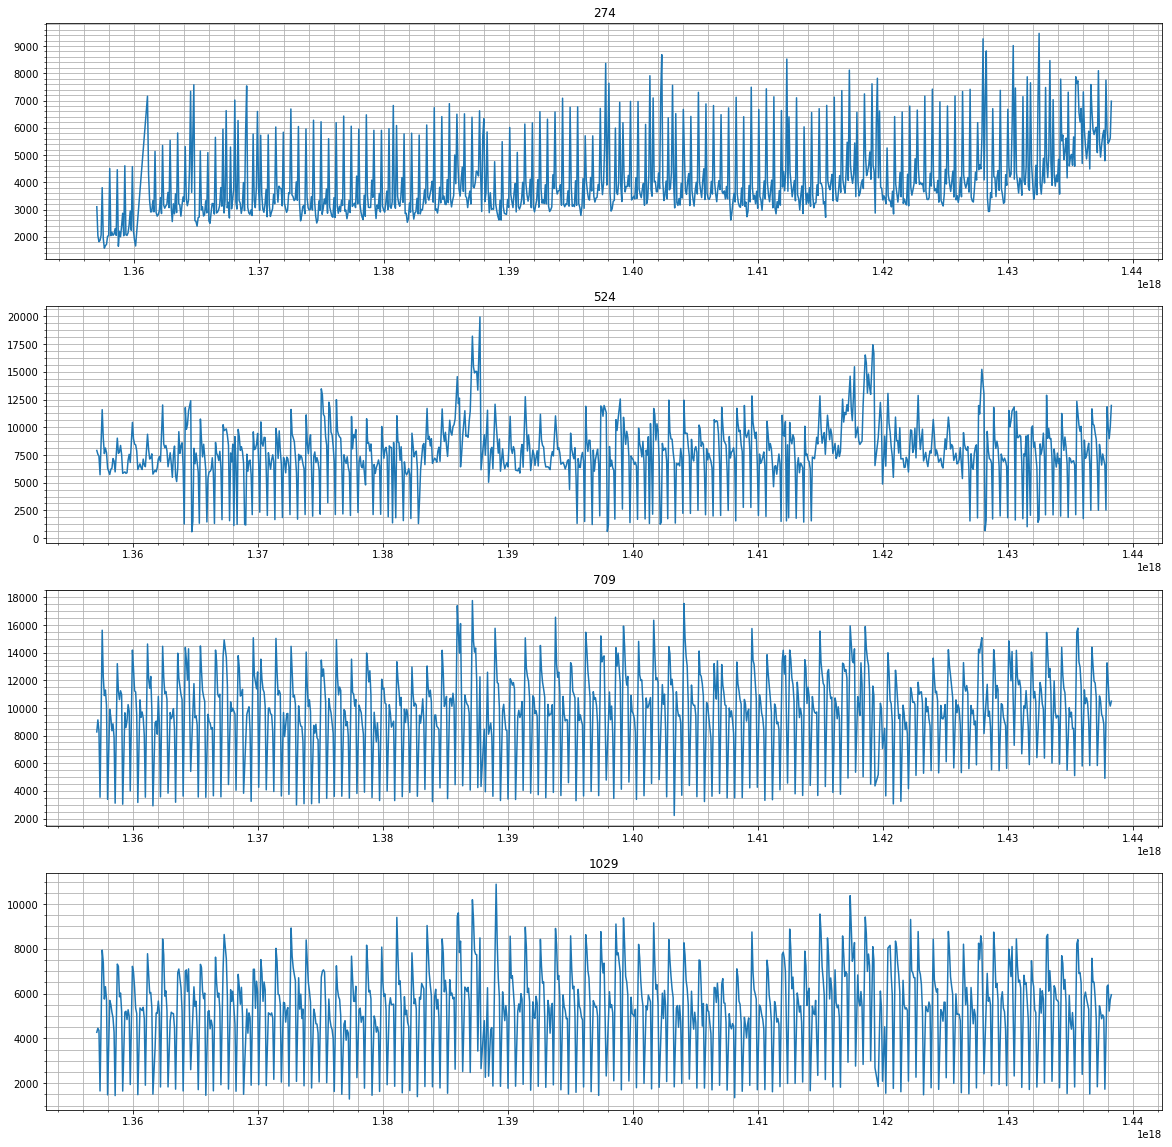

In [84]:
list_stores_to_check = [274,524,709,1029]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

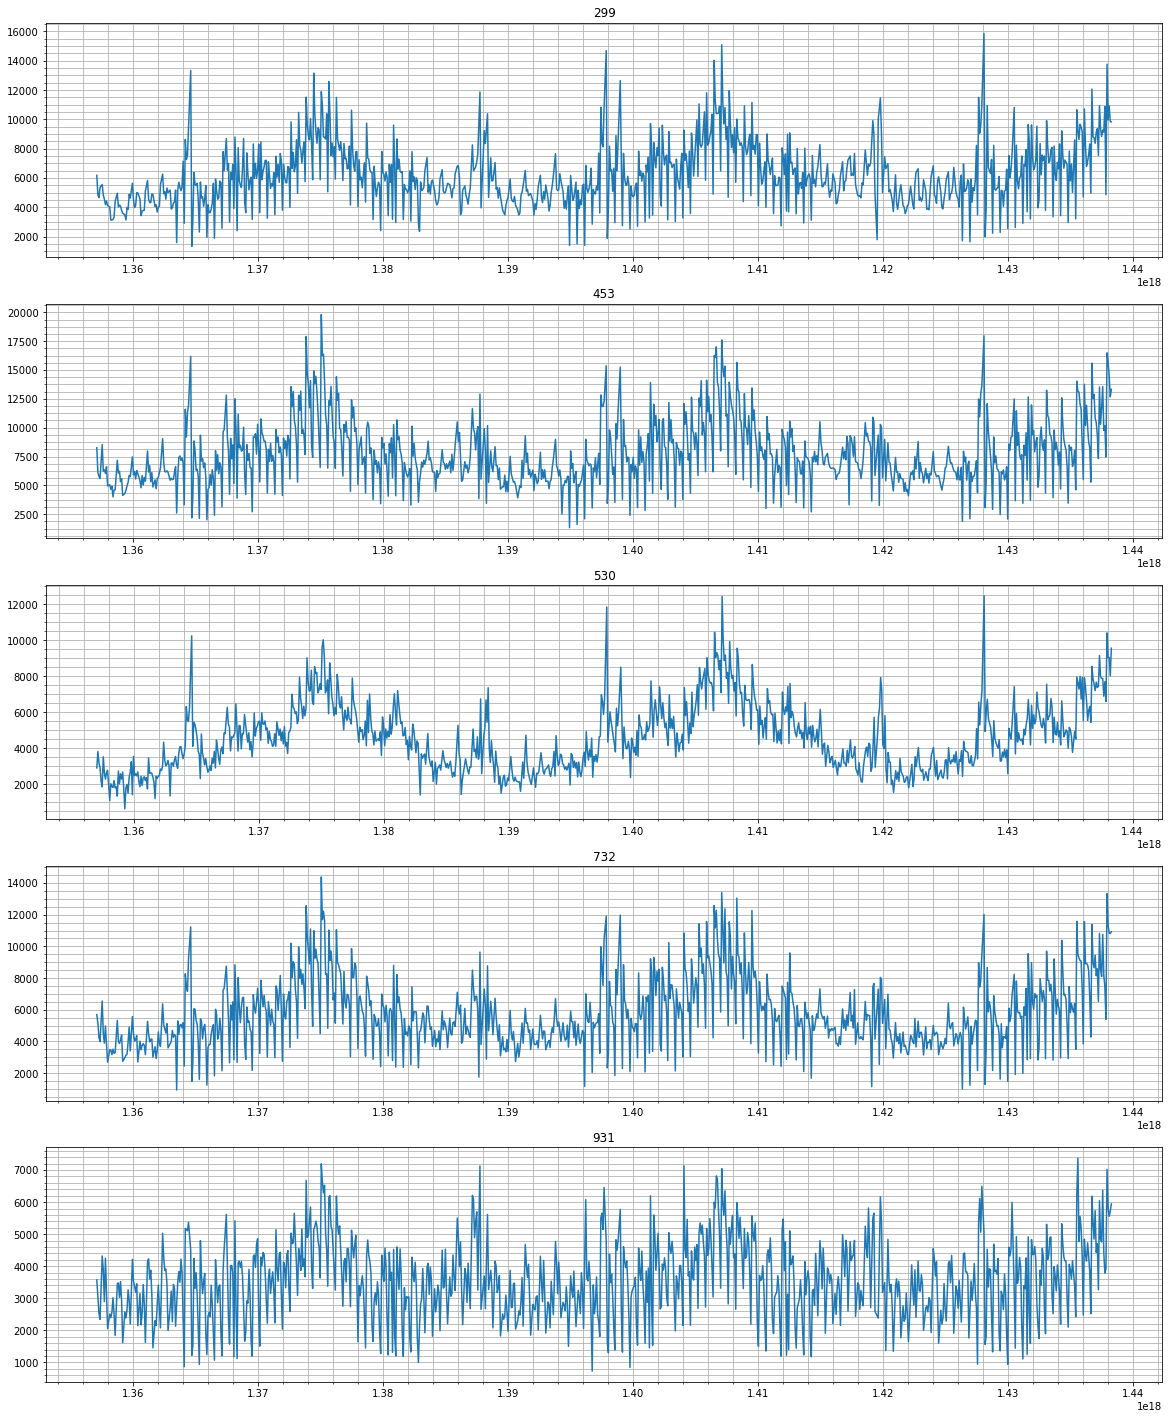

In [85]:
list_stores_to_check = [299,453,530,732,931]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [169]:
store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

for key,value in store_dates_to_remove.items():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

画出删除的数据

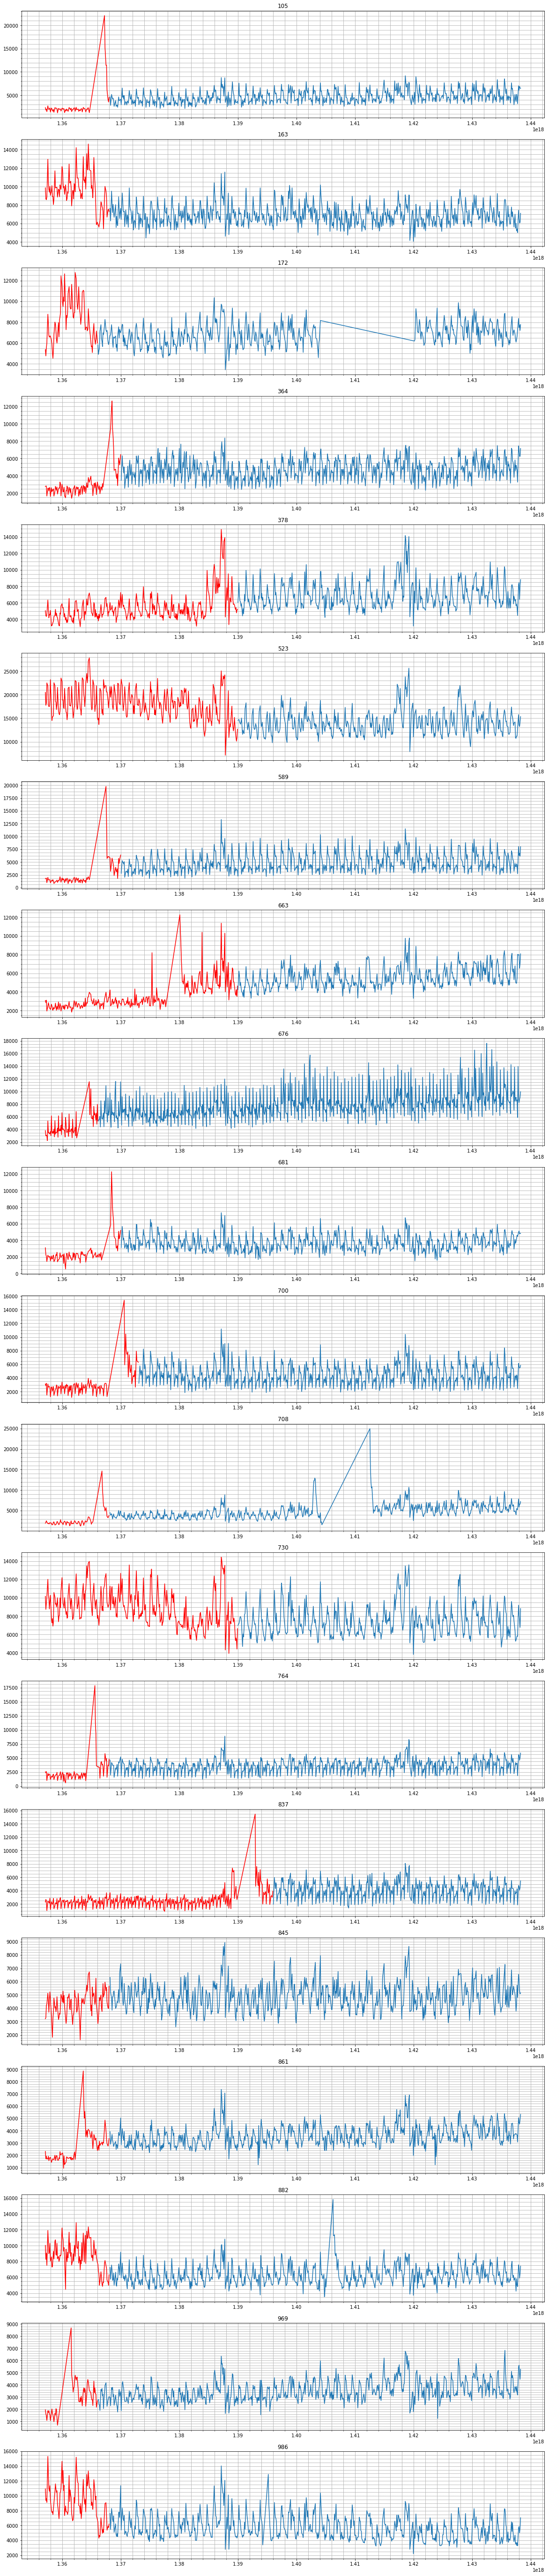

In [92]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]['Sales']
    
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, 'r-')
    plt.plot(X2['DateInt'], y2, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [170]:
### Delete the data where sales in the first period is much different from the rest
df = df.loc[df['Delete'] != True]

## Remove Outliers with Deviation >= 3

In [173]:
# 值得学习，删除了偏差大的Saless数据，再理解一下
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        #将points变为array
        points = points[:,None]
    # 取中位数
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [174]:
for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)

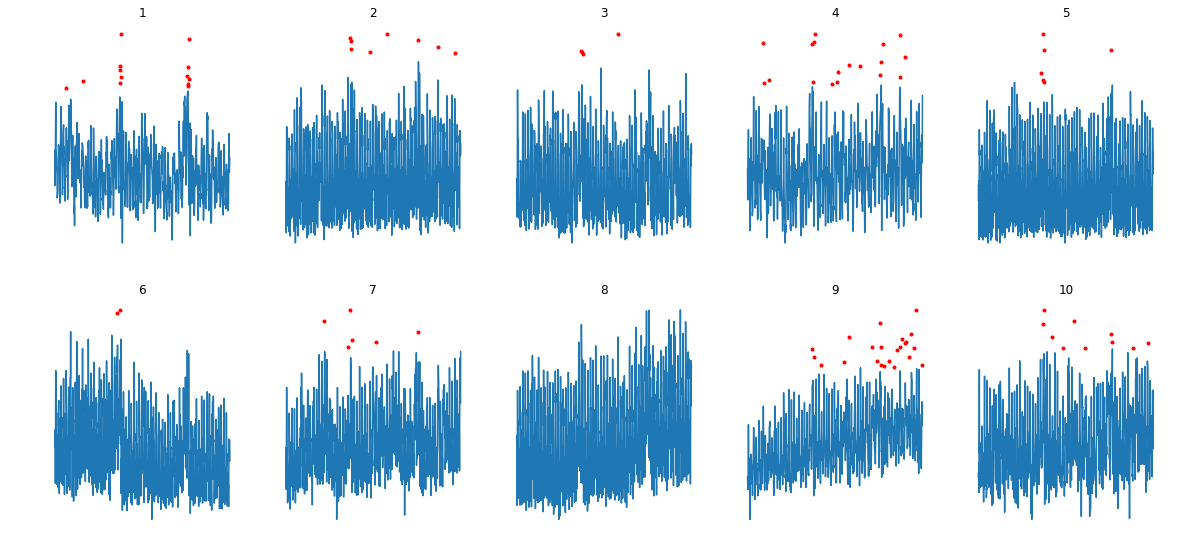

In [175]:
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]['Sales']

    # Outliers
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

## Split Data in Training and Test for Filling in the Outliers

In [176]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

In [177]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [179]:
X_train.head()

DateWeek  Store  SchoolHoliday  StateHoliday  DateDay  CompetitionDistance  DateDayOfYear  DateMonth  DayOfWeek  Assortment  PromoInterval0  Open  DateYear  StoreType  Promo   CompetitionOpenInt
642979        49    445              0             1        2                240.0            336         12          1           0            -1.0   1.0      2013          0      1 -9223372036854775808
128525        15    302              1             1        7               2190.0             97          4          2           2             3.0   1.0      2015          3      0  1196467200000000000
599718         2    669              0             1       10              17080.0             10          1          5           0             1.0   1.0      2014          3      1  1341100800000000000
719121        39    767              0             1       25              13080.0            268          9          3           2            -1.0   1.0      2013          0      1 -9223372036854775808
559977         7   1062              0             0       15                190.0             46          2          6           0             2.0   1.0      2014          3      0  1346457600000000000

In [178]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmse:5.78753	test-rmse:5.78794	train-rmspe:0.996823	test-rmspe:0.996825
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.117328	test-rmse:0.118724	train-rmspe:0.166776	test-rmspe:0.127673
[500]	train-rmse:0.099427	test-rmse:0.102177	train-rmspe:0.129247	test-rmspe:0.109766
[750]	train-rmse:0.09209	test-rmse:0.096206	train-rmspe:0.109794	test-rmspe:0.103235
[1000]	train-rmse:0.087674	test-rmse:0.093	train-rmspe:0.097803	test-rmspe:0.099826
[1250]	train-rmse:0.084814	test-rmse:0.09112	train-rmspe:0.094285	test-rmspe:0.097864
[1500]	train-rmse:0.082518	test-rmse:0.09005	train-rmspe:0.088985	test-rmspe:0.096444
[1750]	train-rmse:0.080751	test-rmse:0.089084	train-rmspe:0.086828	test-rmspe:0.095418
[2000]	train-rmse:0.079247	test-rmse:0.088297	train-rmspe:0.085252	test-rmspe:0.094601
[2250]	train-rmse:0.077992	test-rmse:0.087842	train-rmspe:0.083565	test-rmspe:0.09407

KeyboardInterrupt: 

In [ ]:
dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])

In [ ]:
ypred_bst = bst.predict(dpred)

In [ ]:
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1

In [ ]:
### You see the result being lower than before, but most of them are still pretty high
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]['Sales']

    # Outliers
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

## Generating some extra store data from sales

In [202]:
### Get total sales, customers and open days per store
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

In [203]:
### Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

In [204]:
df_store = pd.merge(df_store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [205]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

## Random Sampling

为了验证为什么该模型训练速度如此快，考虑删除一些特征来检验


In [109]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1)][features_y],
                                                    test_size=0.1, random_state=seed)

------------- 删除（begin） ------------

In [207]:
sub_features_x = features_x

['DateWeek',
 'Store',
 'SchoolHoliday',
 'StateHoliday',
 'DateDay',
 'SalesPerDay',
 'CompetitionDistance',
 'DateDayOfYear',
 'DateMonth',
 'DayOfWeek',
 'Assortment',
 'PromoInterval0',
 'SalesPerCustomersPerDay',
 'Open',
 'DateYear',
 'StoreType',
 'CustomersPerDay',
 'Promo',
 'CompetitionOpenInt']

In [208]:
drop_features = ['PromoInterval0', 'CompetitionOpenInt']
sub_df = df.drop(drop_features, axis=1)
sub_features_x.remove('PromoInterval0')
sub_features_x.remove('CompetitionOpenInt')

In [210]:
len(sub_features_x)

17

In [211]:
X_train, X_test, y_train, y_test = train_test_split(sub_df.loc[(sub_df['Set'] == 1) & (sub_df['Open'] == 1)][sub_features_x],
                                                    sub_df.loc[(sub_df['Set'] == 1) & (sub_df['Open'] == 1)][features_y],
                                                    test_size=0.1, random_state=seed)

------------- 删除（end） ------------

In [212]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [213]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [112]:
param = {'bst:max_depth':12,
         'bst:eta':0.0095,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmse:5.79169	test-rmse:5.79118	train-rmspe:0.996901	test-rmspe:0.9969
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.107746	test-rmse:0.10913	train-rmspe:0.172076	test-rmspe:0.119382
[500]	train-rmse:0.096672	test-rmse:0.099678	train-rmspe:0.15861	test-rmspe:0.109704
[750]	train-rmse:0.091145	test-rmse:0.095574	train-rmspe:0.127117	test-rmspe:0.105609
[1000]	train-rmse:0.087329	test-rmse:0.093048	train-rmspe:0.11679	test-rmspe:0.102995
[1250]	train-rmse:0.084769	test-rmse:0.09159	train-rmspe:0.111603	test-rmspe:0.101585
[1500]	train-rmse:0.082606	test-rmse:0.090484	train-rmspe:0.106921	test-rmspe:0.100541
[1750]	train-rmse:0.080846	test-rmse:0.089938	train-rmspe:0.096944	test-rmspe:0.100093
[2000]	train-rmse:0.079375	test-rmse:0.089443	train-rmspe:0.089658	test-rmspe:0.099496
[2250]	train-rmse:0.078067	test-rmse:0.089054	train-rmspe:0.087629	test-rmspe:0.09884

In [186]:
bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=1, early_stopping_rounds=250)

[0]	train-rmse:5.78753	test-rmse:5.78794	train-rmspe:0.996823	test-rmspe:0.996825
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[1]	train-rmse:4.05873	test-rmse:4.05912	train-rmspe:0.981418	test-rmspe:0.981424
[2]	train-rmse:2.85187	test-rmse:2.85218	train-rmspe:0.937593	test-rmspe:0.937588
[3]	train-rmse:2.01045	test-rmse:2.01076	train-rmspe:0.855531	test-rmspe:0.855432
[4]	train-rmse:1.42719	test-rmse:1.42744	train-rmspe:0.742075	test-rmspe:0.741593
[5]	train-rmse:1.02497	test-rmse:1.02523	train-rmspe:0.617663	test-rmspe:0.616282
[6]	train-rmse:0.753325	test-rmse:0.753502	train-rmspe:0.504274	test-rmspe:0.501113
[7]	train-rmse:0.572336	test-rmse:0.572641	train-rmspe:0.416184	test-rmspe:0.411048
[8]	train-rmse:0.45923	test-rmse:0.459455	train-rmspe:0.361791	test-rmspe:0.353798
[9]	train-rmse:0.389006	test-rmse:0.38938	train-rmspe:0.333601	test-rmspe:0.322948
[10]	train-rmse:0.347729	tes

KeyboardInterrupt: 

In [187]:
X_train.head()

DateWeek  Store  SchoolHoliday  StateHoliday  DateDay  CompetitionDistance  DateDayOfYear  DateMonth  DayOfWeek  Assortment  PromoInterval0  Open  DateYear  StoreType  Promo   CompetitionOpenInt
642979        49    445              0             1        2                240.0            336         12          1           0            -1.0   1.0      2013          0      1 -9223372036854775808
128525        15    302              1             1        7               2190.0             97          4          2           2             3.0   1.0      2015          3      0  1196467200000000000
599718         2    669              0             1       10              17080.0             10          1          5           0             1.0   1.0      2014          3      1  1341100800000000000
719121        39    767              0             1       25              13080.0            268          9          3           2            -1.0   1.0      2013          0      1 -9223372036854775808
559977         7   1062              0             0       15                190.0             46          2          6           0             2.0   1.0      2014          3      0  1346457600000000000

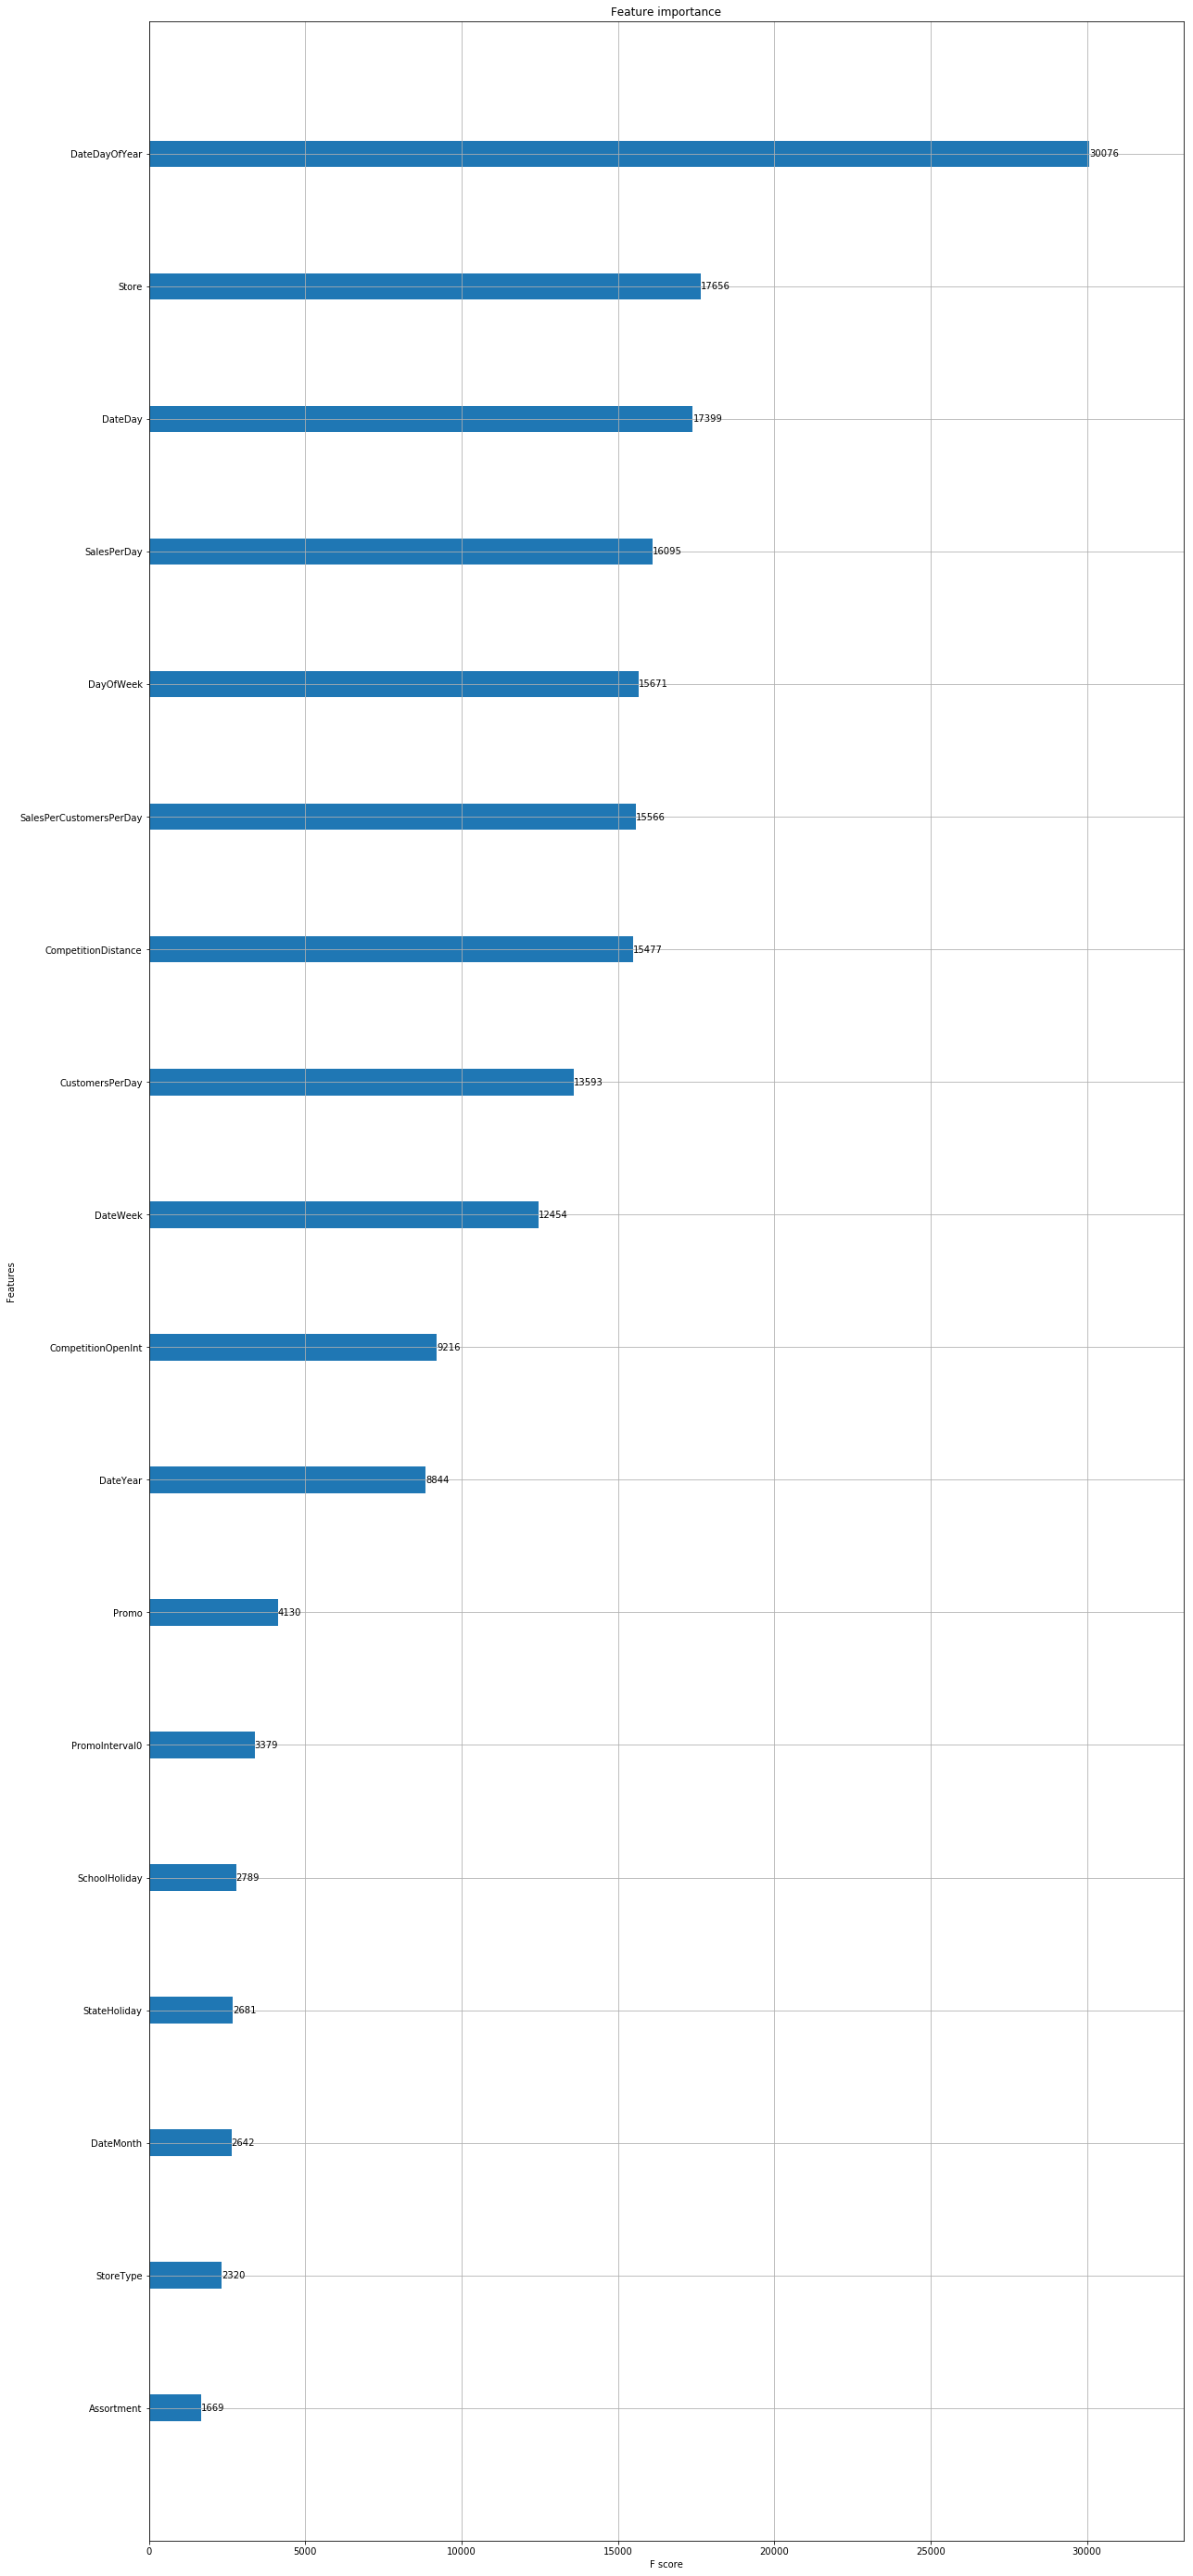

In [113]:
xgb.plot_importance(bst1)

## Export data

In [ ]:
X_submit = df.loc[df['Set'] == 0]

In [ ]:
dsubmit = xgb.DMatrix(X_submit[features_x])

ypred_bst = bst1.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(ypred_bst) - 1) * 0.985

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_best_no_ext_data_scaled.csv', index=False)